In [75]:
import networkx as nx
import numpy as np
import heapq
import math
import random
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import collections
import time
import psutil
import os

In [76]:
def get_memory_usage():
  process = psutil.Process(os.getpid())
  # return the bytes
  return process.memory_info().rss

Generate Graph with only low doubling dimension:

In [77]:
def generate_low_doubling_dimension_graph(n, dim=2, radius=0.2):
  G = nx.random_geometric_graph(n, radius)

  # Get the position dictionary
  pos = nx.get_node_attributes(G, 'pos')

  # Add weights based on Euclidean distances
  for (u, v) in G.edges():
      dist = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))
      G[u][v]['weight'] = dist

  return G, pos

Generate Random Geometric Graphs with Low Doubling Dimension

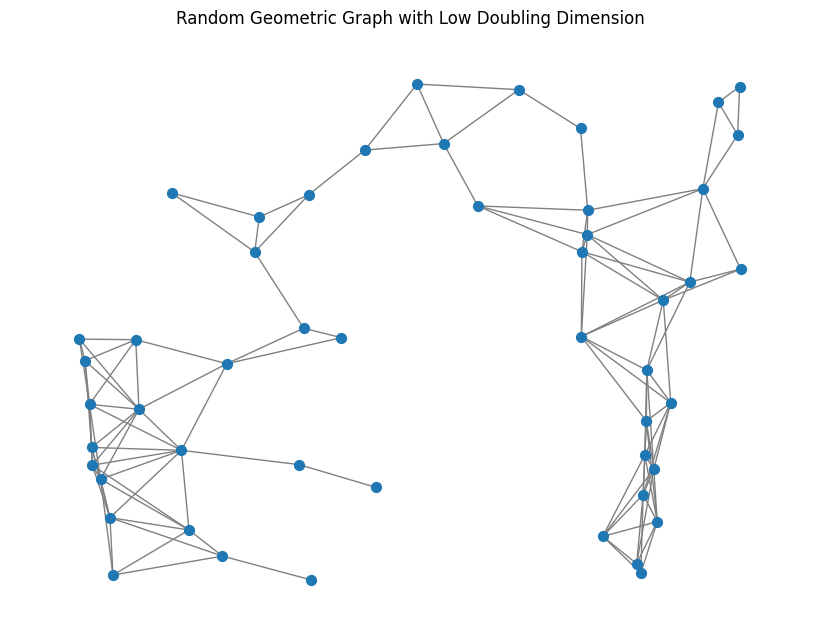

In [99]:
def generate_low_doubling_and_highway_graph(n, dim=2, radius=0.2):
    # generate n random points in a dim-dimensional space
    points = np.random.rand(n, dim)

    # create a k-d tree for efficient nearest neighbor search
    tree = cKDTree(points)

    # find all pairs within the radius
    edges = tree.query_pairs(radius)

    # fill the graph
    G = nx.Graph()
    for i in range(n):
        G.add_node(i, pos=points[i])

    for u, v in edges:
        G.add_edge(u, v)

    return G, points

def plot_graph(G, points):
    pos = {i: points[i] for i in range(len(points))}
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=False, node_size=50, edge_color="gray")
    plt.title("Random Geometric Graph with Low Doubling Dimension")
    plt.show()

# parameters
num_nodes = 50
dimension = 2  # Low dimension ensures low doubling dimension
connection_radius = 0.2

# generate and plot the graph
G, points = generate_low_doubling_dimension_graph(num_nodes, dimension, connection_radius)
plot_graph(G, points)

Verify that the graphs have low doubling dimension:

In [81]:
def estimate_doubling_constant(G, num_samples=10, r_fraction=0.1):
    nodes = list(G.nodes)
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    # compute approximate max distance in the graph
    max_dist = max(max(d.values()) for d in shortest_path_lengths.values())

    r = int(r_fraction * max_dist)  # set radius as a fraction of max distance
    doubling_constants = []

    for _ in range(num_samples):
        # pick a random node
        center = random.choice(nodes)

        # compute number of nodes within distance r and 2r
        B_r = {node for node, dist in shortest_path_lengths[center].items() if dist <= r}
        B_2r = {node for node, dist in shortest_path_lengths[center].items() if dist <= 2*r}

        if len(B_r) > 0:  # avoid division by zero
            doubling_constants.append(len(B_2r) / len(B_r))

    # compute the estimated doubling constant
    estimated_C = max(doubling_constants) if doubling_constants else float('inf')

    return estimated_C

In [82]:
print(estimate_doubling_constant(G))
G_prime, _ = generate_low_doubling_dimension_graph(50)
print(estimate_doubling_constant(G_prime))

1.0
3.4


Estimate the Highway Dimensionality

Function to create the graphs needed in the sample

In [83]:
# create a representitive sample of nodes in the graph for each node sample size
def genGraphSamples(num_nodes, numSamples, lo_hi_lo_doub):
  graphs = []
  for _ in range(numSamples):
    if not lo_hi_lo_doub:
      G, _ = generate_low_doubling_dimension_graph(num_nodes)
      while not nx.is_connected(G) and estimate_doubling_constant(G) > 6:
        G, _ = generate_low_doubling_dimension_graph(num_nodes)
      graphs.append(G)
    else:
      G, _ = generate_low_doubling_and_highway_graph(num_nodes)
      while not nx.is_connected(G) and estimate_doubling_constant(G) > 6:
        G, _ = generate_low_doubling_and_highway_graph(num_nodes)
      graphs.append(G)
  return graphs

Create the sample sets for each node size

In [84]:
def samplesPerNodeSizeDict(lo_hi_lo_doub):
  node_sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
  size_to_samp = collections.defaultdict(list)
  for size in node_sizes:
    graphs = genGraphSamples(size, 10, lo_hi_lo_doub)
    size_to_samp[size] = graphs
  return size_to_samp

Create the representative sample:

In [92]:
sample_dict_lo_hi_lo_doub = samplesPerNodeSizeDict(True)
sample_dict_lo_doub = samplesPerNodeSizeDict(False)

[<networkx.classes.graph.Graph object at 0x79ef7f9e5c10>, <networkx.classes.graph.Graph object at 0x79ef7f869b10>, <networkx.classes.graph.Graph object at 0x79ef82bf6a50>, <networkx.classes.graph.Graph object at 0x79ef7f870ed0>, <networkx.classes.graph.Graph object at 0x79ef7f898490>, <networkx.classes.graph.Graph object at 0x79ef7f8abfd0>, <networkx.classes.graph.Graph object at 0x79ef7f8ab390>, <networkx.classes.graph.Graph object at 0x79ef7f8b8e10>, <networkx.classes.graph.Graph object at 0x79ef7f8937d0>, <networkx.classes.graph.Graph object at 0x79ef7f8c7d90>]


Implement Bi-Di Bellman-Ford.

In [96]:
def bi_bellman_ford(G, s, t):
  start_time = time.time()
  mem_usage = []
  # keep track of the nodes
  nodes = G.nodes

  # keep track of the distances between nodes on the shortest path
  dist_fwd = {node: float('inf') for node in nodes}
  dist_fwd[s] = 0

  dist_back = {node: float('inf') for node in nodes}
  dist_back[t] = 0

  # keep track of how or if we are updating
  # if done updating the algo stops running
  updated_fwd = True
  updated_back = True

  # iterate potentially over all nodes
  for _ in range(len(nodes) - 1):
    mem_usage.append(get_memory_usage())
    if not updated_fwd and not updated_back:
      # if we found the shortest path, iterate no more
      break

    # get ready for a new iteration of updates
    updated_fwd = False
    updated_back = False
    temp_dist_fwd = dist_fwd.copy()
    temp_dist_back = dist_back.copy()

    # check forward edge
    for u, v, weight in G.edges(data='weight'):
      if weight is None:
        continue
      if dist_fwd[u] + weight < temp_dist_fwd[v]:
        temp_dist_fwd[v] = dist_fwd[u] + weight
        updated_fwd = True

      # check reverse edge
      if dist_fwd[v] + weight < temp_dist_fwd[u]:
        temp_dist_fwd[u] = dist_fwd[v] + weight
        updated_fwd = True

    # check backward edge
    for u, v, weight in G.edges(data='weight'):
      if weight is None:
        continue
      if dist_back[u] + weight < temp_dist_back[v]:
        temp_dist_back[v] = dist_back[u] + weight
        updated_back = True

      # check reverse edge
      if dist_back[v] + weight < temp_dist_back[u]:
        temp_dist_back[u] = dist_back[v] + weight
        updated_back = True

    # update the forward distances
    dist_fwd = temp_dist_fwd
    # update the backward distances
    dist_back = temp_dist_back

  shortest_path = float('inf')
  for node in nodes:
    if dist_fwd[node] + dist_back[node] < shortest_path:
      shortest_path = dist_fwd[node] + dist_back[node]
  end_time = time.time()

  return shortest_path, (end_time - start_time), np.average(mem_usage)

Implement Bi-Di Dijkstras

In [97]:
def bi_dijkstras(G, s, t):
  start_time = time.time()
  mem_usage = []
  # keep track of the nodes
  nodes = G.nodes

  # keep track of the distance between node pairs from the forward search
  fwd_dist = {node: float('inf') for node in nodes}
  fwd_dist[s] = 0

  # keep track of the distance between node pairs from the backward search
  back_dist = {node: float('inf') for node in nodes}
  back_dist[t] = 0

  fwdHeap = [(0, s)]
  backHeap = [(0, t)]

  shortest_path_dist = float('inf')

  fwd_seen = set()
  back_seen = set()

  while fwdHeap and backHeap:
    mem_usage.append(get_memory_usage())
    fwd_dist_node, node = heapq.heappop(fwdHeap)
    if node in fwd_seen:
      continue
    fwd_seen.add(node)

    if fwd_dist_node > shortest_path_dist:
      # if we've found the shortest path stop iteration
      break

    #iterate over neighbors and add them to the heap should there be a shortest path
    for nei, data in G[node].items():
      weight = data.get('weight', None)
      if weight is None:
        continue
      if fwd_dist[node] + weight < fwd_dist[nei]:
        fwd_dist[nei] = fwd_dist[node] + weight
        heapq.heappush(fwdHeap, (fwd_dist[nei], nei))

    back_dist_node, node = heapq.heappop(backHeap)
    if node in back_seen:
      continue
    back_seen.add(node)
    if back_dist_node > shortest_path_dist:
      # if we've found the shortest path stop iteration
      break

    # iterate over the neighbors and add them to the heap should there be a shortest path
    for nei, data in G[node].items():
      weight = data.get('weight', None)
      if weight is None:
        continue
      if back_dist[node] + weight < back_dist[nei]:
        back_dist[nei] = back_dist[node] + weight
        heapq.heappush(backHeap, (back_dist[nei], nei))

    for node in fwd_seen:
      if node in back_seen:
        shortest_path_dist = min(shortest_path_dist, fwd_dist[node] + back_dist[node])

    end_time = time.time()
    after_mem = get_memory_usage()
  return shortest_path_dist, (end_time - start_time), np.average(mem_usage)

In [88]:
def plotRuntimeAndPeakMemory(sample_dict):
  node_sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

  avg_bf_time = []
  avg_bf_memory = []
  avg_dij_time = []
  avg_dij_memory = []

  for size in node_sizes:
    graphs = sample_dict[size]
    bellman_ford_sp = []
    bellman_ford_times = []
    bellman_ford_peak_memory = []
    dijkstras_sp = []
    dijkstras_times = []
    dijkstras_peak_memory = []
    for G in graphs:
      s = random.choice(list(G.nodes))
      t = random.choice(list(G.nodes))

      bf_sp, bf_time, bf_peak = bi_bellman_ford(G, s, t)
      bellman_ford_sp.append(bf_sp)
      bellman_ford_times.append(bf_time)
      bellman_ford_peak_memory.append(bf_peak)

      dij_sp, dij_time, dij_peak = bi_dijkstras(G, s, t)
      dijkstras_sp.append(dij_sp)
      dijkstras_times.append(dij_time)
      dijkstras_peak_memory.append(dij_peak)

    # store the averages
    avg_bf_time.append(np.mean(bellman_ford_times))
    avg_bf_memory.append(np.mean(bellman_ford_peak_memory))
    avg_dij_time.append(np.mean(dijkstras_times))
    avg_dij_memory.append(np.mean(dijkstras_peak_memory))

  # Plot 1: Runtime Comparison
  plt.figure(figsize=(8, 6))
  plt.plot(node_sizes, avg_bf_time, label="Bellman-Ford", marker="o")
  plt.plot(node_sizes, avg_dij_time, label="Dijkstra", marker="s")
  plt.xlabel("Number of Nodes")
  plt.ylabel("Average Runtime (seconds)")
  plt.title("Runtime Comparison of Bellman-Ford and Dijkstra")
  plt.legend()
  plt.grid()
  plt.show()

  # Plot 2: Peak Memory Comparison
  plt.figure(figsize=(8, 6))
  plt.plot(node_sizes, avg_bf_memory, label="Bellman-Ford", marker="o")
  plt.plot(node_sizes, avg_dij_memory, label="Dijkstra", marker="s")
  plt.xlabel("Number of Nodes")
  plt.ylabel("Average Peak Memory (Bytes)")
  plt.title("Peak Memory Usage Comparison")
  plt.legend()
  plt.grid()
  plt.show()

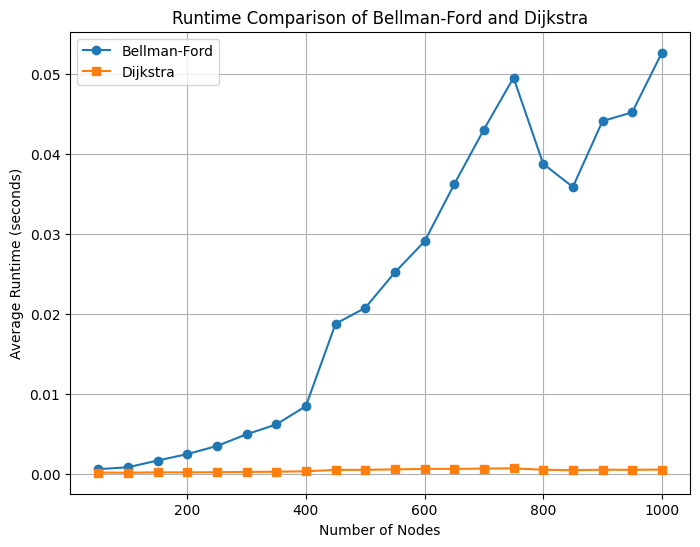

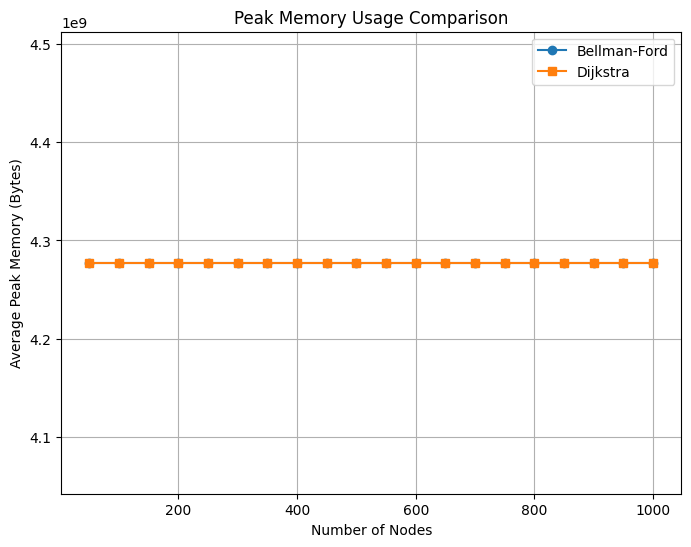

In [98]:
plotRuntimeAndPeakMemory(sample_dict_lo_hi_lo_doub)

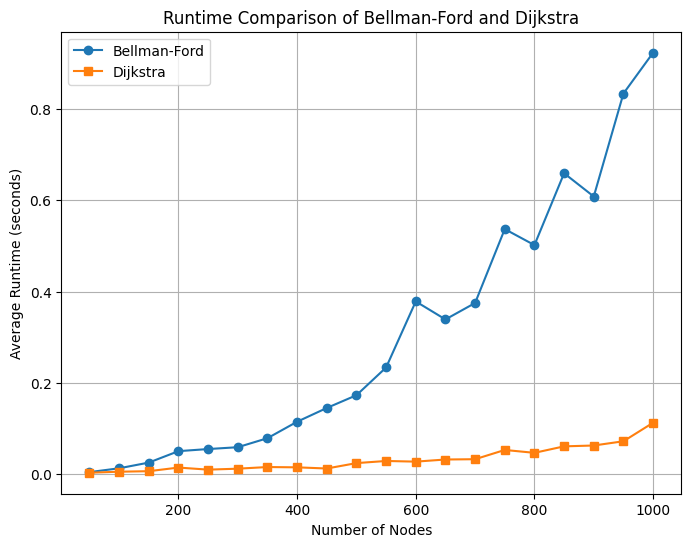

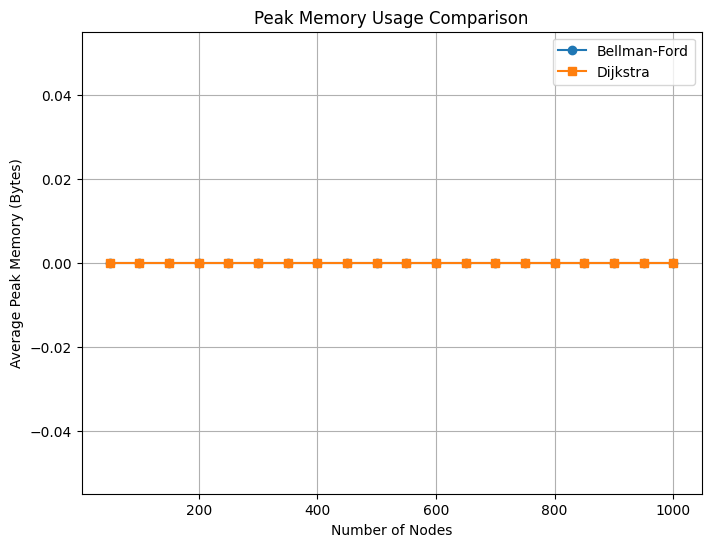

In [94]:
plotShortestPathRuntimeAndPeakMemory(sample_dict_lo_doub)

Tester Code for Bi-Di Algos (Tester Code Generated with the help of Google Gemini):

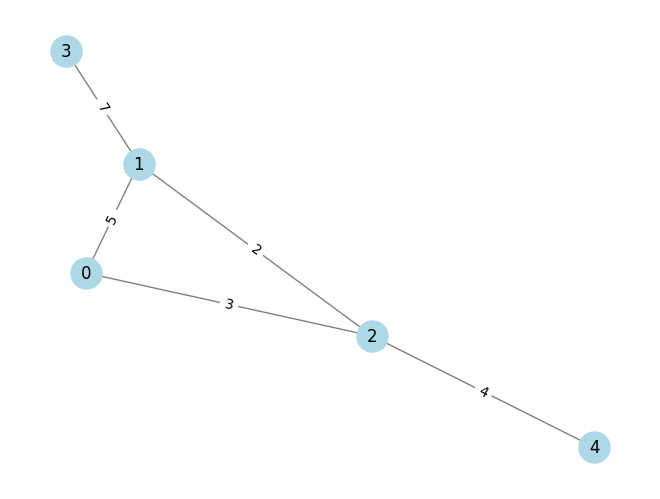

13
13


In [ ]:
# Create a simple graph with 5 nodes and some edges
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1, {'weight': 5}), (0, 2, {'weight': 3}), (1, 2, {'weight': 2}), (1, 3, {'weight': 7}), (2, 4, {'weight': 4})])

pos = nx.spring_layout(G)  # Define node positions using spring layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

print(bi_bellman_ford(G, 3, 4))
print(bi_dijkstras(G, 3, 4))

In [ ]:
def generate_random_weighted_graph(num_nodes_min=10, num_nodes_max=30, edge_factor_min=2, edge_factor_max=10, weight_min=1, weight_max=10):
  """Generates a random graph with random edge weights."""
  num_nodes = random.randint(num_nodes_min, num_nodes_max)
  num_edges = random.randint(num_nodes * edge_factor_min, num_nodes * edge_factor_max)

  G = nx.gnm_random_graph(num_nodes, num_edges)

  # Add random weights to edges
  for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(weight_min, weight_max)

  return G
def test():
  G = generate_random_weighted_graph()

  # Generated with Google Gemini:
  pos = nx.spring_layout(G)  # Define node positions using spring layout
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
  plt.show()
  #end code generation

  source = random.choice(list(G.nodes))
  target = random.choice(list(G.nodes))

  # use the shortest path algo from NX compare against algos
  control_sp = nx.shortest_path_length(G, source=source, target=target, weight='weight')
  bi_bellman_ford_sp = bi_bellman_ford(G, source, target)
  bi_dijkstras_sp = bi_dijkstras(G, source, target)

  print(f"Control Shortest Path: {control_sp}")
  print(f"Bi-Di Bellman-Ford Shortest Path: {bi_bellman_ford_sp}")
  print(f"Bi-Di Dijkstras Shortest Path: {bi_dijkstras_sp}")

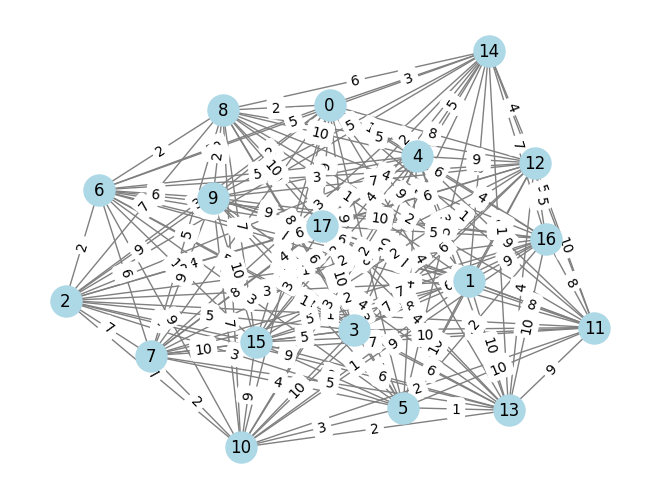

Control Shortest Path: 4
Bi-Di Bellman-Ford Shortest Path: 4
Bi-Di Dijkstras Shortest Path: 4


In [ ]:
test()